Сердечно-сосудистые заболевания являются являются одной из основных причин смерти в мире (http://www.who.int/ru/news-room/fact-sheets/detail/the-top-10-causes-of-death), поэтому важно анализировать прецеденты, чтобы помогать пациентам в будущем. Методы анализа данных могут нам помочь выявить факторы, которые могут быть связаны с возникновением таких болезней. В качестве примера, возьмем датасет South African Heart Disease (https://web.stanford.edu/~hastie/ElemStatLearn/data.html), на котором разберем взаимосвязи некоторых характеристик с ишемической болезнью сердца и выявим параметр, который вносит наибольшее влияние на развитие болезни в итоговой модели. Краткая сводка про датасет: 

A retrospective sample of males in a heart-disease high-risk region
of the Western Cape, South Africa. There are roughly two controls per
case of CHD. Many of the CHD positive men have undergone blood
pressure reduction treatment and other programs to reduce their risk
factors after their CHD event. In some cases the measurements were
made after these treatments. These data are taken from a larger
dataset, described in  Rousseauw et al, 1983, South African Medical
Journal. 

sbp		systolic blood pressure
tobacco		cumulative tobacco (kg)
ldl		low densiity lipoprotein cholesterol
adiposity
famhist		family history of heart disease (Present, Absent)
typea		type-A behavior
obesity
alcohol		current alcohol consumption
age		age at onset
chd		response, coronary heart disease

Выполним препроцессинг данных: загрузим данные и необходимые библиотеки для работы с ними.

In [11]:
# Загружаем библиотеки
import numpy as np # работа с векторами
import matplotlib.pyplot as plt # рисовать графики
import pandas as pd # для работы с матрицами

names = ['sbp', 'tobacco', 'ldl', 'adiposity', 'famhist', 'typea', 'obesity', 'alcohol', 'age', 'chd']
disease = pd.read_csv("SAheart.csv")

In [12]:
#В переменной famhist значения приведем к числовому выражению:
famhist = {'Absent': 0,'Present': 1} 
disease.famhist = [famhist[item] for item in disease.famhist] 
disease.head()

,row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,0,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,1,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,1,60,25.99,57.34,49,1


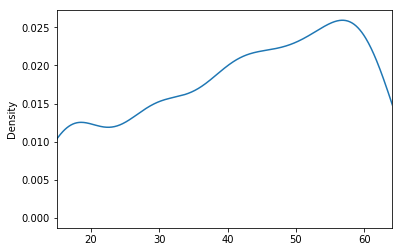

In [4]:
disease["age"].plot("kde", xlim=(disease["age"].min(), disease["age"].max()))

В таблице можно видеть первые 5 строк набора данных, где spb-age - различные характеристики, которые, вероятно, могут повлиять на возникновение болезни, а chd - наличие (1) или отсутствие болезни (0).

На графике - плотность распределения возрастов участников выборки.

Далее подготовим основу для анализа:
* выделим целевую переменную (у) и предикторы (Х)
* разобьем на тестовую и обучающую выборки наш датасет
* построим простые модели: логистическую регрессию, логистическую регрессию с регуляризацией и дерево решений (все они необходимы впоследствии для вычисления ансамбля).

In [47]:
X = disease.iloc[:, 0:9].values
y = disease.iloc[:,9].values

In [16]:
# тестовая - обучающая
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# логистическая регрессия
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg.score(X_train, y_train), logreg.score(X_test, y_test)

(0.7337662337662337, 0.7207792207792207)

In [40]:
# с регуляризацией
logreg2 = LogisticRegression(C=4)
logreg2.fit(X_train, y_train)
logreg2.score(X_train, y_train), logreg2.score(X_test, y_test)

(0.737012987012987, 0.7207792207792207)

In [20]:
# дерево
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
tree.score(X_train, y_train), tree.score(X_test, y_test)

(1.0, 0.6623376623376623)

Лучшую классифицирующую способность показали модели на основе регрессии, из них лучше всего обучился ансамбль Voting:

In [73]:
# Voting
from sklearn.ensemble import VotingClassifier
modelVote = VotingClassifier(estimators=[('lr', logreg), ('dt', tree), ('lrreg', logreg2)], voting='hard')
modelVote.fit(X_train,y_train)
modelVote.score(X_train,y_train), modelVote.score(X_test,y_test)

c:\users\kuruma\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\kuruma\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(0.7402597402597403, 0.7207792207792207)

Среди прочих были исследованы модели: бэггинг, стакинг, бустинг (ada, gradient), random forest. Но так как простая модель логистической регрессии с регуляризацией дает соответствующее качество предсказания, то в дальнейшем будем использовать ее. 

Модели на основа дерева, лучше обучаются, но имеют меньший показатель accuracy. Наилучшей оказалась модель ExtraTrees:

In [34]:
from sklearn.ensemble import ExtraTreesClassifier
modelET = ExtraTreesClassifier(n_estimators=100, max_features=5)
modelET.fit(X_train, y_train)
modelET.score(X_train, y_train), modelET.score(X_test, y_test)

(1.0, 0.6948051948051948)

Определим значимость переменных в модели логистической регрессии с регуляризацией, и в модели Extra Trees для сравнения. Воспользуемся пакетом eli5, в котором реализованы соответствующий моделям алгоритм feature_importances_.

In [96]:
import eli5
eli5.explain_weights_df(logreg2, feature_names=names[0:9])

,target,feature,weight
0,1,famhist,0.835293
1,1,ldl,0.136960
2,1,tobacco,0.112026
3,1,adiposity,0.061320
4,1,typea,0.037801
5,1,age,0.035432
6,1,alcohol,-0.002232
7,1,sbp,-0.008013
8,1,obesity,-0.128243
9,1,<BIAS>,-2.855706


In [95]:
eli5.show_weights(logreg2)

Weight?,Feature
+0.835,x4
+0.137,x2
+0.112,x1
+0.061,x3
+0.038,x5
+0.035,x8
-0.002,x7
-0.008,x0
-0.128,x6
-2.856,<BIAS>


Таблица показывает, что наибольший вес имеют характеристики famhist, ldl и tobacco. Однако эти значения соответствуют коээфициентам регрессии и необязательно вносят наибольший вклад из-за разницы в методах измерения (см. примечание ? в колонке Weight)

Рассмотрим модель Extra Trees:

In [53]:
eli5.explain_weights_df(modelET, feature_names=names[0:9])

,feature,weight,std
0,age,0.174783,0.048932
1,tobacco,0.158691,0.037399
2,ldl,0.116973,0.028860
3,adiposity,0.105857,0.038030
4,typea,0.105421,0.025369
5,alcohol,0.100343,0.027246
6,obesity,0.096582,0.025415
7,sbp,0.093514,0.027514
8,famhist,0.047836,0.014395


Из данной таблицы можно сделать вывод, что наибольший вклад вносит возраст. Это потверждается другими данными (например, https://medbe.ru/materials/profilaktika-serdtsa-i-sosudov/vliyanie-pola-i-vozrasta-na-risk-vozniknoveniya-serdechno-sosudistykh-zabolevaniy/) и логикой: чем старше человек, тем больше факторов риска данной болезни он перенес или имеет в настоящий момент.

In [79]:
eli5.show_weights(modelET)

Weight,Feature
0.1748 ± 0.0979,x8
0.1587 ± 0.0748,x1
0.1170 ± 0.0577,x2
0.1059 ± 0.0761,x3
0.1054 ± 0.0507,x5
0.1003 ± 0.0545,x7
0.0966 ± 0.0508,x6
0.0935 ± 0.0550,x0
0.0478 ± 0.0288,x4


Таким образом, в качестве итоговой модели выберем ExtraTrees, так как она хорошено обучена, имеет приемлемое качество классификации, и в ней можно адекватно выявить значимость переменных.
Рассмотрим влияние переменной age также с помощью метода "potential outcomes". Модель содержит три объекта: 
Y - age, целевая переменная, значение которой мы сравниваем в разных группах
D - chd, переменная, по которой мы разделяем данные на группы treatment - control
X - famhist, переменная, потенциально влияющая на связь между Y и D (в логистической регрессии она имела наибольший вес, тогда как в дереве - наименьший. Посмотрим на ее проявление в модели):

In [97]:
from causalinference import CausalModel
causal = CausalModel(Y = disease['age'].values,
                     D = disease['chd'].values,
                     X = disease['famhist'].values)

In [98]:
causal.est_via_ols(adj = 0)
print(causal.estimates)

c:\users\kuruma\appdata\local\programs\python\python36-32\lib\site-packages\causalinference\estimators\ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]



Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     11.439      1.198      9.548      0.000      9.091     13.788



In [99]:
causal.est_via_ols()
print(causal.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     10.355      1.276      8.116      0.000      7.854     12.856
           ATC     10.552      1.358      7.773      0.000      7.891     13.213
           ATT      9.983      1.242      8.041      0.000      7.550     12.417



Значение АТЕ (оценка в среднем по группе, аналог разницы между группой, в которой есть воздействие, и группой, где этого воздействия нет) изменяется несильно, показатель ATE близок показателю ATT (то есть данные близки к тем, что могли быть получены в случайном эксперименте). P-value меньше 0.05, это значит что результаты статистически значимы. Процедура выравнивания выборок (matching) не изменила результатов. Таким образом, между исследуемыми переменными имеется связь.

К сожалению, на практике мы не можем омолодить пациентов, или сделать так, чтобы в его семье не было членов с сердечно-сосудистыми болезнями. Однако мы можем принимать полученные данные во внимание для профилактики и диагностики заболеваний. Также необходимы консультации врачей-специалистов, которые могут поставить иные задачи и гипотезы для проверки.